In [10]:
import openslide
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import mstats
from functools import reduce
from operator import mul
import os
import glob
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [12]:
"""
Helper functions.
"""

def factors(n,k):   
    """
    Returns kth largest factor of an int. Needed for finding equally sized grids in our image.
    """
    facs = reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))
    #print("Factors of %d are :" % n, facs)
    return sorted(facs)[-k], facs


def enoughFactors(arr,minNoFactors):
    
    """
    Pads image dimensions to make dimensions have more factors if needed.
    """

    (_,rowFactors),(_,colFactors) = map(lambda dim: factors(dim,0),arr.shape)
    enoughFactors = (len(rowFactors) >= minNoFactors) and (len(colFactors) >= minNoFactors)
    while enoughFactors == False:
        if len(rowFactors) < minNoFactors:
            arr = np.pad(arr,((2,0),(0,0)),"reflect")
            (_,rowFactors),(_,colFactors) = map(lambda dim: factors(dim,0),arr.shape)

        if len(colFactors) < minNoFactors:
            arr = np.pad(arr,((0,0),(2,0)),"reflect")
            (_,rowFactors),(_,colFactors) = map(lambda dim: factors(dim,0),arr.shape)
        
        enoughFactors = (len(rowFactors) >= minNoFactors) and (len(colFactors) >= minNoFactors)
        
    return arr

def chosenFactor(arr,factors):
    """
    Given array and set of factors of the dimensions, returns factors which are most similar aspect ratio wise
    to the array.
    """
    rowFactors,colFactors = factors
    chosenWindow = 10000
    for i in rowFactors:
        for j in colFactors:
            shape = arr.shape[0]/i,arr.shape[1]/j
            aspectRatioWin = float(shape[1])/shape[0]
            aspectRatioImg = float(arr.shape[1])/arr.shape[0]
            aspectRatioDiff = aspectRatioWin - aspectRatioImg
            if aspectRatioDiff < chosenWindow:
                chosenWindow = (i,j)

    return chosenWindow

def closestLevel(levelDims,w):
    differences = map(lambda dim: (abs(dim[1]-w), abs(dim[1]-w)),levelDims)
    areas = map(lambda levelDims: reduce(mul,levelDims),(differences))
    level = [idx for idx,area in enumerate(areas) if area == min(areas)][0]
    return level


def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h/int(nrows), nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def pad(arr,windowSize):
    
    """
    Pads array to be divisible by window size.
    """
    
    divisible = False
    while divisible == False:
        if  arr.shape[0] % windowSize != 0:
            arr = np.pad(arr,((0,2),(0,0)),"constant")
        if  arr.shape[1] % windowSize != 0:
            arr = np.pad(arr,((0,0),(0,2)),"constant")

        if all([dim % windowSize ==0 for dim in arr.shape])==True:
                divisible = True
    return arr

def getBoxCoords(blocksPair,level,upscaleLevel):
    
    """
    Returns information to load region of high resolution image. Given indicies blocks for x and y,
    low resolution image level and desired output level.
    """
    x = blocksPair[1]
    x1 = x[0][0]
    x2 = x[0][-1]
    y = blocksPair[0]
    y1 = y[0][0]
    y2 = y[-1][0]
    #print("X",x1,x2)
    #print("Y",y1,y2)
    upscaledX0 = map(lambda coord: np.power(2,level)*coord, (x1,x2)) #Level 0 x coords needed for region initial value
    upscaledY0 = map(lambda coord: np.power(2,level)*coord, (y1,y2)) #Level 1 y coords needed for region initial value
    #return (upscaledX),(upscaledY)
    location = (upscaledX0[0],upscaledY0[0])
    upscaledX = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (x1,x2))
    upscaledY = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (y1,y2))
    size = ((upscaledX[1] - upscaledX[0]),(upscaledY[1] - upscaledY[0]))
    return location, size, ((x1,x2),(y1,y2))

percentage255 = lambda block: np.sum(block==255).astype("float64")/block.size # Calculates percentage of array = 255.

def removeFiles(path):
    """
    Remove all files in a path.
    """
    files = glob.glob(path+"*")
    for f in files:
        os.remove(f)

In [28]:
"""
Main image object.
"""

class her2Image():
    def __init__(self,caseNumber,minNoFactors,threshArea,windowSize,blackThresh,blurSize):
        
        case = groundTruth.loc[groundTruth.CaseNo==caseNumber]
        self.score, self.percScore = case["HeR2 SCORE"].values[0], case["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"].values[0]

        self.her2 = openslide.open_slide('data/'+str(caseNumber)+'_HER2.ndpi') # Main image object in wdi format
        #self.he = openslide.open_slide('data/'+str(caseNumber)+'_HE.ndpi')
        self.nLevels = self.her2.level_count # Number of levels
            
        #self.level = closestLevel(self.her2.level_dimensions,1000)
        self.level = 6
        self.lowResDims = self.her2.level_dimensions[self.level] #3 is arbitrary but works
        self.lowResRGB = np.asarray(self.her2.read_region((0,0),self.level,(self.lowResDims[0],self.lowResDims[1]))).copy() 
        
        #plt.imshow(self.lowResRGB)
        #plt.show()
        
        #Remove black
        black = np.logical_and.reduce((self.lowResRGB[:,:,0] > blackThresh,
                                       self.lowResRGB[:,:,1] > blackThresh,
                                       self.lowResRGB[:,:,2] > blackThresh, 
                                       self.lowResRGB[:,:,3] > blackThresh))
        black4 = np.dstack([black for i in range(3)])
        self.lowResRGB[np.logical_not(black4)] = mstats.mode(self.lowResRGB[:,:,:3],axis=None)[0]
        
        
        self.lowRes = cv2.cvtColor(self.lowResRGB, cv2.COLOR_RGB2GRAY) # Grayscale
        self.lowResArea = reduce(mul,self.lowResDims) # Area of image
        self.mode = mstats.mode(self.lowRes,axis=None)[0]
        
        # Thresholded image
        img = cv2.GaussianBlur(self.lowRes,(blurSize,blurSize),0)
        ret,self.thresh = cv2.threshold(img,mstats.mode(img,axis=None)[0]-4,255,1)
        
        # Padd lowRes image and thresholded to make factors 
        self.lowRes, self.thresh = [pad(arr,windowSize) for arr in (self.lowRes, self.thresh)]
        
        (_,rowFactors),(_,colFactors) = map(lambda dim: factors(dim,8),self.lowRes.shape)
        nrows, ncols = chosenFactor(self.lowRes,(rowFactors,colFactors))
        nrows, ncols = windowSize, windowSize

        coordsX,coordsY = np.indices((self.lowRes.shape[0],self.lowRes.shape[1]))
        blocksX,blocksY = blockshaped(coordsX,nrows,ncols),blockshaped(coordsY,nrows,ncols)
        blocksThresh = blockshaped(self.thresh,nrows,ncols)
        blocksLowRes = blockshaped(self.lowRes,nrows,ncols)

        self.relaventCoords = [] # ROIs

        #featureBlocks = np.where(np.any(blocksThresh==255,axis=(1,2)))[0]
        featureBlocks = np.where(np.array([percentage255(block) for block in blocksThresh])>threshArea)[0] # Percentage covered
        for block in featureBlocks:
            self.relaventCoords.append((blocksX[block],blocksY[block]))
        
    def show(self):
        
        plt.imshow(self.lowResRGB)
        plt.title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        plt.show()
        plt.imshow(self.thresh,cmap=cm.gray)
        plt.show()
             
    def regionGen(self,upscaleLevel): 
        for i in range(len(self.relaventCoords)):
            location, size, ((x1,x2),(y1,y2)) = getBoxCoords(self.relaventCoords[i],self.level,upscaleLevel)
            cv2.rectangle(self.lowResRGB, (x1, y1), (x2, y2), (255,0,0), 2)
            region = np.asarray(eg.her2.read_region((location[0],location[1]),upscaleLevel,(size[0],size[1])))
            yield region
            


Image 33 with score of 3, percScore of 100.


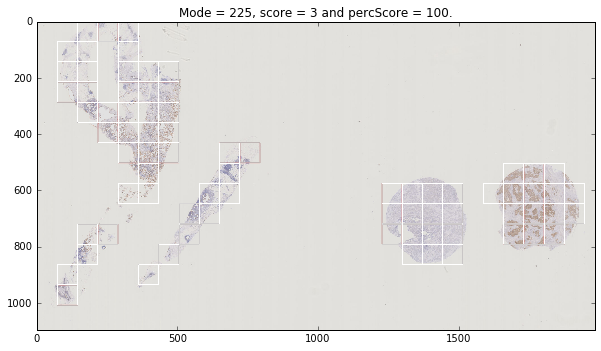

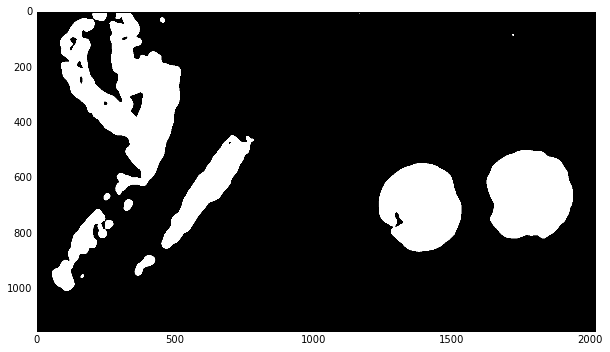

Number of regions generated = 76 with dimension 2272 x 2272 x 4.
Image 83 with score of 3, percScore of 100.


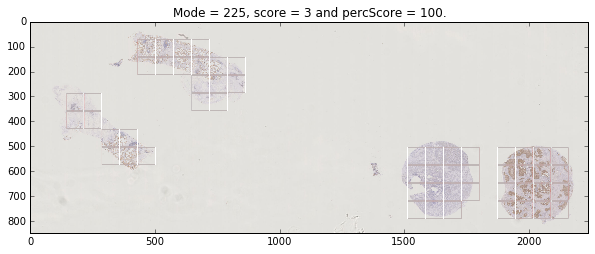

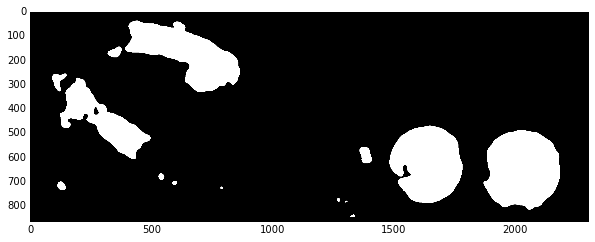

Number of regions generated = 55 with dimension 2272 x 2272 x 4.
Image 36 with score of 2, percScore of 100.


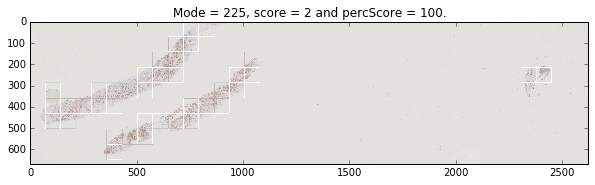

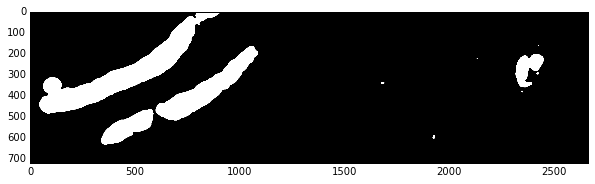

Number of regions generated = 40 with dimension 2272 x 2272 x 4.
('Smallest y: ', 2272)
('Smallets x: ', 2272)
('Biggest y: ', 2272)
('Biggest x: ', 2272)


In [36]:
numberOfRegions = []
imagesWithLines = [84,82,35]
if __name__ == "__main__":

    # Hyperparams
    minNoFactors = 10
    threshArea = 0.4
    upscaleLevel= 1
    save = 1
    show = 1
    displayProb = 0.00
    windowSize = 72
    blackThresh = 120
    blurSize = 47
    
    # Dimensions check
    dims = []
    
    # CSV
    writePath = "/home/msmith/her2/data/"
    groundTruth = pd.read_csv("data/groundTruth.csv")
    cols = {1: "CaseNo", 2: "HeR2 SCORE",
           3:"PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"}
    #groundTruthLowStain = groundTruth.loc[groundTruth.ix[:,2]<=50]
    #groundTruthHighStain = groundTruth.loc[groundTruth.ix[:,2]>90]
    groundTruth.sort_values(by=cols[3],inplace=True)
    
    
    # Generate ROIs and saave jpg
    for caseNo in groundTruth.CaseNo.values[-3:]:
    #for caseNo in imagesWithLines:
        
        nRegions = 0
        
        newpath = writePath + "roi_" + str(caseNo) + "/"
        if save == 1:
            removeFiles(newpath)
            if not os.path.exists(newpath):
                os.makedirs(newpath)

        eg = her2Image(caseNo,minNoFactors,threshArea,windowSize,blackThresh,blurSize)
        print("Image %d with score of %d, percScore of %d." % (caseNo,eg.score,eg.percScore))
        regions = eg.regionGen(upscaleLevel) # region object
        regionNo = 0
        caseDims = [] 
        for region in regions:
            nRegions += 1
            if np.random.uniform() < displayProb and show == 1:
                plt.imshow(region)
                plt.show()
            if save == 1:
                region = region[:,:,:3] # remove alpha
                region = region[:,:,::-1] # swap rgb
                cv2.imwrite(newpath + str(regionNo) + ".jpg",region)
            regionNo += 1
            caseDims.append(region.shape)
            #print("All alpha values == 255? %r" % np.all(region[:,:,3]==255))
            
        dims.append(caseDims)
        eg.show()
        numberOfRegions.append(nRegions)
        print("Number of regions generated = %d with dimension %d x %d x 4." % (nRegions,caseDims[0][0],caseDims[0][1]))

print("Smallest y: ", min([x[0][0] for x in dims]))
print("Smallets x: ", min([x[0][1] for x in dims]))

print("Biggest y: ", max([x[0][0] for x in dims]))
print("Biggest x: ", max([x[0][1] for x in dims]))